In [11]:
# Import libraries

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [12]:
# Load data
df = pd.read_csv('UsArrests.csv',index_col=0)

df.head()

,Murder,Assault,UrbanPop,Rape
City,,,,
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


Missing values:
Murder      0
Assault     0
UrbanPop    0
Rape        0
dtype: int64

Data Types:
Murder      float64
Assault       int64
UrbanPop      int64
Rape        float64
dtype: object

Aggregating Statistics:
         Murder     Assault   UrbanPop       Rape
count  50.00000   50.000000  50.000000  50.000000
mean    7.78800  170.760000  65.540000  21.232000
std     4.35551   83.337661  14.474763   9.366385
min     0.80000   45.000000  32.000000   7.300000
25%     4.07500  109.000000  54.500000  15.075000
50%     7.25000  159.000000  66.000000  20.100000
75%    11.25000  249.000000  77.750000  26.175000
max    17.40000  337.000000  91.000000  46.000000



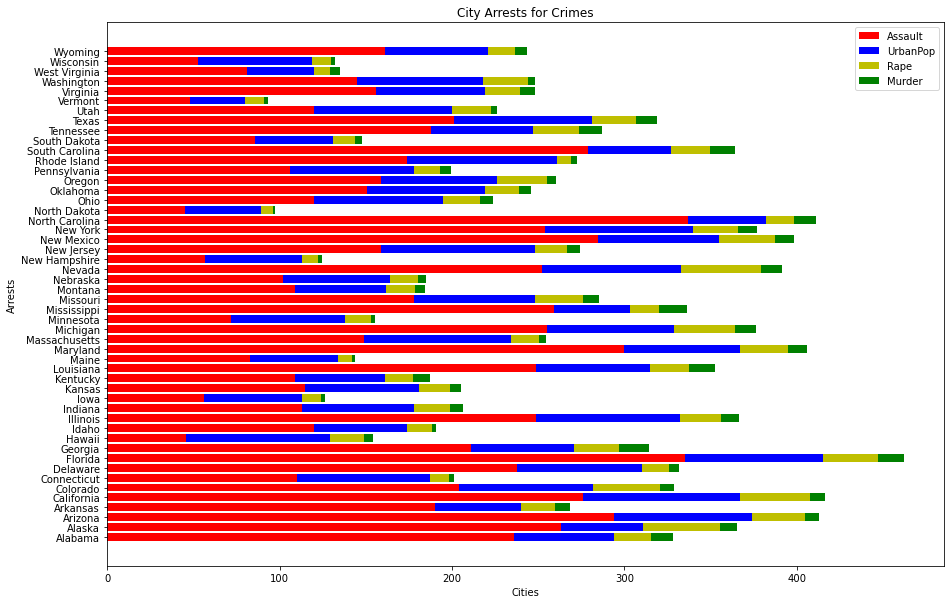

In [13]:
#check misiing values
print('Missing values:')
print(df.isnull().sum(), end='\n\n')

#check datatypes
print('Data Types:')
print(df.dtypes, end='\n\n')

#aggregating statistics for all columns
print('Aggregating Statistics:')
print (df.describe(), end='\n\n') #df.agg(["min", "max", "mean", "std"],) for specific with statistics

# Visualizing arrests for different crimes in different Cities
x = df.index#['City']
y1 = df['Assault']
y2 = df['UrbanPop']
y3 = df['Rape']
y4 = df['Murder']

plt.figure(figsize=(15,10))
plt.barh(x, y1, color='r')
plt.barh(x, y2, left=y1, color='b')
plt.barh(x, y3, left=y1+y2, color='y')
plt.barh(x, y4, left=y1+y2+y3, color='g')
plt.xlabel("Cities")
plt.ylabel("Arrests")
plt.legend(["Assault", "UrbanPop", "Rape", "Murder"])
plt.title("City Arrests for Crimes")
plt.show()

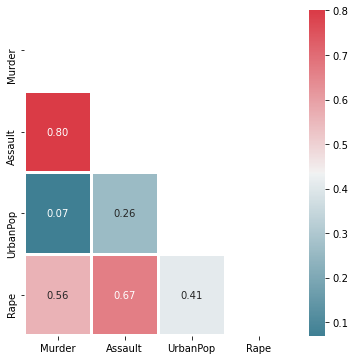

In [14]:
colormap = sns.diverging_palette(220, 10, as_cmap=True)

def corr_heatmap(df):
  # get correlations
  corrs = df.corr()

  # pick appropriate palette for heatmap

  # Plot figsize
  fig, ax = plt.subplots(figsize=(6, 6))

  # to mask mirrored side of heatmap
  dropSelf = np.zeros_like(corrs)
  dropSelf[np.triu_indices_from(dropSelf)] = True

  # Generate Heat Map, with annotations of the correlation strength and 2-decimal floats
  ax = sns.heatmap(corrs, cmap=colormap, annot=True, fmt=".2f", mask=dropSelf, linewidth=2)

  plt.show()

corr_heatmap(df)

In [15]:
# select and standardize features
X = StandardScaler().fit_transform(df.values)   #[["Assault", "UrbanPop", "Rape", "Murder"]]) 

# choose number of components to be generated
nr_comps = 2
pca = PCA(n_components=nr_comps)

# obtain components
principal_components = pca.fit_transform(X)

# transform the components into a pandas data frame
pca_df = pd.DataFrame(principal_components, index=df.index)

# prepare data for training
x_scaled = pca_df.values.reshape(-1,2)

# This is to include the country code  as the rownames in the PC's
pca_df.head()

,0,1
City,,
Alabama,0.985566,1.133392
Alaska,1.950138,1.073213
Arizona,1.763164,-0.745957
Arkansas,-0.141420,1.119797
California,2.523980,-1.542934


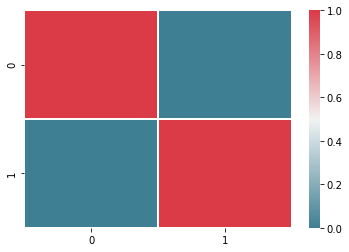

In [16]:
#Plot the transformed version of the data.
ax = sns.heatmap(pca_df.corr(), cmap=colormap,linewidth=1)
plt.show()

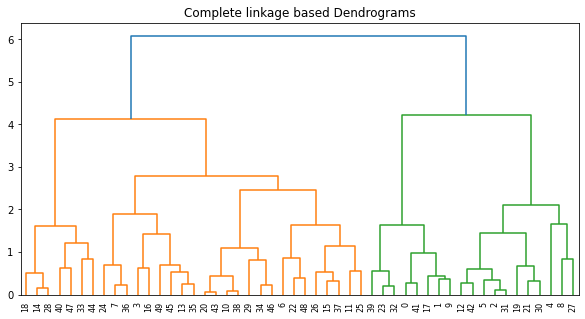

In [17]:
#printing dendograms for 
plt.figure(figsize=[10,5])
plt.title("Complete linkage based Dendrograms")  
dend = dendrogram(linkage(x_scaled, method='complete'))

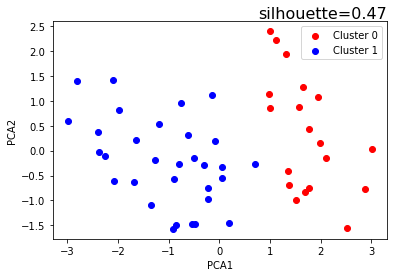

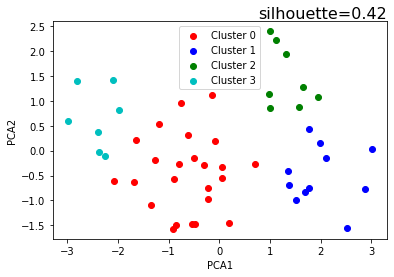

In [18]:
from sklearn.metrics import accuracy_score, silhouette_score
from statistics import mean

def scatter_hierarchical(x_scaled, k, r=123):
    cluster = AgglomerativeClustering(n_clusters=k,  linkage='complete')
    y_pred = cluster.fit_predict(x_scaled)
    colours = 'rbgcmy'
    for c in range(k):
      plt.scatter(x_scaled[y_pred == c, 0], x_scaled[y_pred == c,1],
                  c = colours[c], label = 'Cluster {}'.format(c))
          
    score = round(silhouette_score(x_scaled, cluster.labels_, metric='euclidean'),2)
    plt.title('silhouette={}'.format(score), loc='right', fontdict={'fontsize': 16}, pad=-14)
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    plt.legend()
    plt.show()

for k in (2,4):
  scatter_hierarchical(x_scaled, k, r=0)

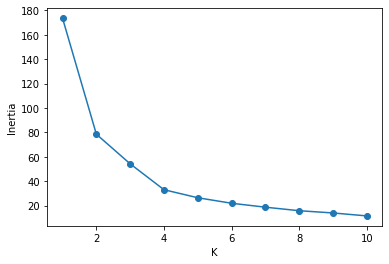

In [19]:
def eval_Kmeans(x_scaled, k, r):
    kmeans = KMeans(n_clusters=k, random_state=r)
    kmeans.fit(x_scaled)    
    return kmeans.inertia_

def elbow_Kmeans(x_scaled, max_k=10, r=123):
    within_cluster_vars = [eval_Kmeans(x_scaled, k, r) for k in range(1,max_k+1)]
    plt.plot(range(1,11), within_cluster_vars,marker='o')
    plt.xlabel('K')
    plt.ylabel('Inertia')
    plt.show()

elbow_Kmeans(x_scaled)

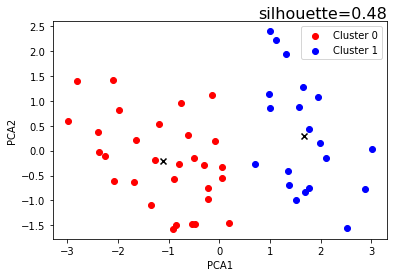

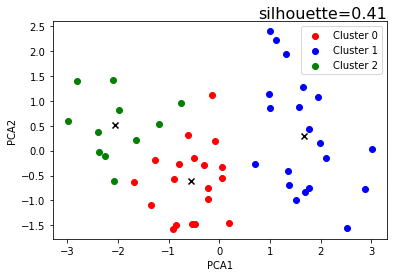

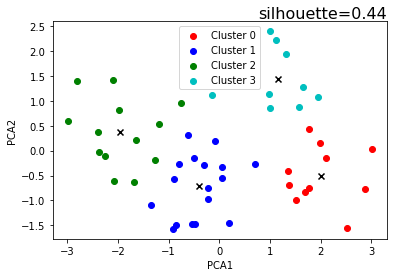

In [20]:
def scatter_Kmeans(x_scaled, k, r=123):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=r)
    y_pred = kmeans.fit_predict(x_scaled)
    colours = 'rbgcmy'
    for c in range(k):
      plt.scatter(x_scaled[y_pred == c, 0], x_scaled[y_pred == c,1], c = colours[c], label = 'Cluster {}'.format(c))
      plt.scatter(kmeans.cluster_centers_[c, 0], kmeans.cluster_centers_[c, 1], marker='x', c = 'black')
    
    score = round(silhouette_score(x_scaled, kmeans.labels_, metric='euclidean'),2)
    plt.title('silhouette={}'.format(score), loc='right', fontdict={'fontsize': 16}, pad=-14)
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    plt.legend()
    plt.show()

for k in range(2,5):
  scatter_Kmeans(x_scaled, k, r=0)
  